# Recipe Recommender System Model

This notebook presents the python code used to build a recipe recommender system based on BPR.

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline

In [4]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [5]:
def getAllUsersWithReviews(start_path, files):
    users = set()
    for file in files:
        try:
            with open(start_path + file + "/reviews.json") as data_file:    
                reviews = json.load(data_file)
                for review in reviews:
                    users.add(review["submitter"]["userID"])
        except: 
            print("Problem with file: " + file)
    return users

In [ ]:
users = getAllUsersWithReviews("recipe_data/", recipes)

In [ ]:
len(users)

In [ ]:
userRecipes = {}
recipeUsers = {}

for user in users:
    userRecipes[user] = []

for recipe in recipes:
    recipeUsers[recipe] = []

for recipe in recipes:
    with open("recipe_data/" + recipe + "/reviews.json") as data_file:
        reviews = json.load(data_file)
        for review in reviews:
            user = review["submitter"]["userID"]
            userRecipes[user].append(recipe)
            recipeUsers[recipe].append(user)

In [ ]:
with open("data/userRecipes.json", "w") as file:
    file.write(json.dumps(userRecipes))

with open("data/recipeUsers.json", "w") as file:
    file.write(json.dumps(recipeUsers))

In [13]:
with open("data/userRecipes.json", "r") as file:
    userRecipes = json.loads(file.read())

with open("data/recipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

In [14]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

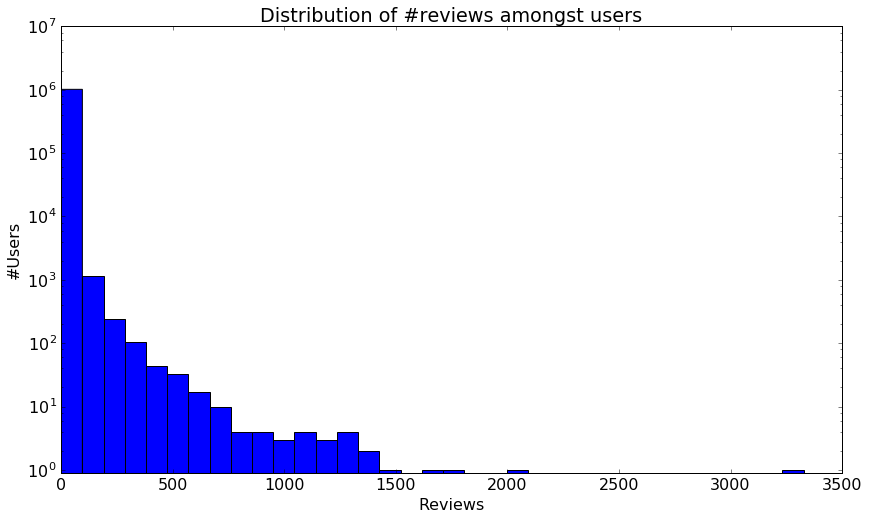

In [15]:
userDistrib = list(map(lambda x: len(userRecipes[x]), users))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(userDistrib, bins=35,log=True)
pl.title('Distribution of #reviews amongst users')
pl.xlabel('Reviews')
pl.ylabel('#Users')
font = {'family' : 'sans-serif',
        'size'   : 16}

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

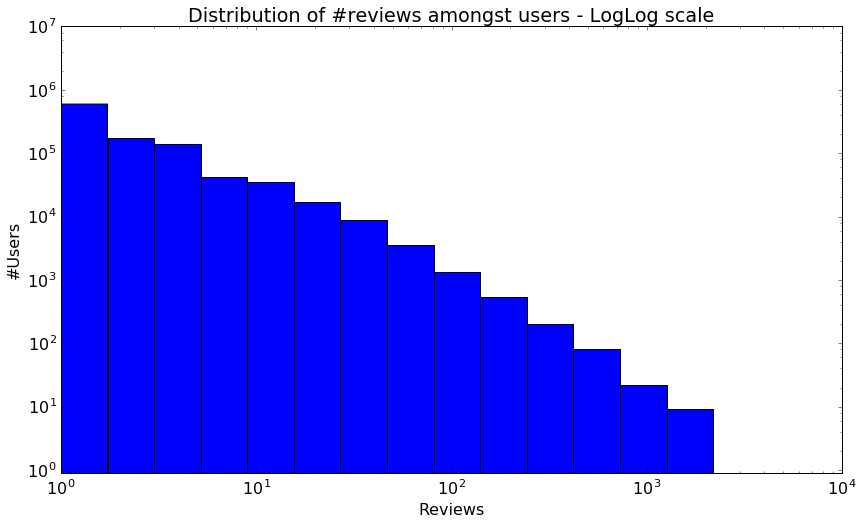

In [16]:
plt.hist(userDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #reviews amongst users - LogLog scale')
pl.xlabel('Reviews')
pl.ylabel('#Users')

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

In [17]:
pdUserDistrib = pd.DataFrame(userDistrib)
pdUserDistrib.columns = ["nb reviews"]
pdUserDistrib.describe()

,nb reviews
count,1.017178e+06
mean,3.306215e+00
std,1.245852e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.327000e+03


In [18]:
for i in [3, 5, 10, 20, 50, 100]:
    print(str(len(pdUserDistrib[pdUserDistrib["nb reviews"] >= i])) + " users with at least than " + str(i) + " reviews")

249586 users with at least than 3 reviews
135320 users with at least than 5 reviews
58247 users with at least than 10 reviews
22805 users with at least than 20 reviews
5104 users with at least than 50 reviews
1523 users with at least than 100 reviews


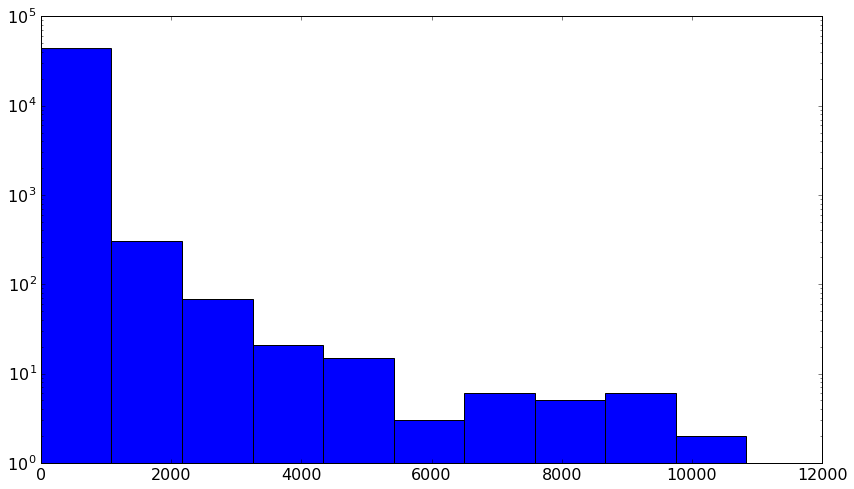

In [19]:
recipeDistrib = list(map(lambda x: len(recipeUsers[x]), recipes))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(recipeDistrib,  log=True)
plt.show()

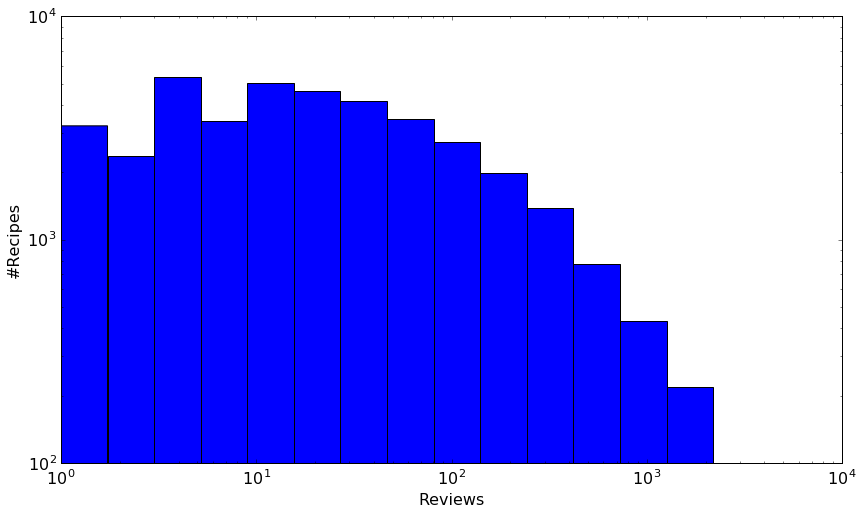

In [20]:
plt.hist(recipeDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.xlabel('Reviews')
pl.ylabel('#Recipes')

axes = plt.gca()
matplotlib.rc('font', **font)
plt.show()

In [21]:
pdrecipeDistrib = pd.DataFrame(recipeDistrib)
pdrecipeDistrib.columns = ["nb reviews"]
pdrecipeDistrib.describe()

,nb reviews
count,44069.000000
mean,76.312351
std,293.079980
min,0.000000
25%,3.000000
50%,12.000000
75%,47.000000
max,10835.000000


## Building Model

In [11]:
'''# Sample 1000 recipes and 10000 users for test
N = 1000
M = 10000

sampleRecipes = np.random.choice(list(recipes), N)
sampleUsers = []
while len(sampleUsers) < M:
    r = np.random.choice(sampleRecipes)
    if(len(recipeUsers[r]) > 1):
        u = np.random.choice(recipeUsers[r])
        if str(u) not in sampleUsers:
            sampleUsers.append(str(u))
            '''

In [12]:
  '''W = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        if sampleRecipes[i] in userRecipes[sampleUsers[j]]:
            W[i,j] = 1  '''

In [21]:
  '''sampleInteractions = []

for user in sampleUsers:
    for recipe in sampleRecipes:
        if recipe in userRecipes[user]:
            sampleInteractions.append((recipe, user))  '''

In [134]:
interactions = []
for user in users:
    if len(userRecipes[user]) >= 5:
        for recipe in userRecipes[user]:
            interactions.append((recipe, user))

#interactions = np.array(sampleInteractions)

In [135]:
_iter = 10**7; # number of iterations
alpha = 0.05; # learning rate
_lambda = 0.01; # regularizer
sigma = 0.1; # std for random initialization
mu = 0.0; # mean for random initialization
K = 10; # number of latent factors 
N = len(users)
M = len(recipes)

# Split test-train 

userRecipes_tr = {}
for interaction in interactions:
    r = interaction[0]
    u = interaction[1]
    if u not in userRecipes_tr.keys():
        userRecipes_tr[u] = [r]
    else:
        userRecipes_tr[u].append(r)

interactions_te = []
userRecipes_te = {}
for user in userRecipes_tr.keys():
    test_recipe = np.random.choice(userRecipes_tr[user])
    userRecipes_tr[user].remove(test_recipe)
    userRecipes_te[user] = test_recipe
    interactions_te.append((test_recipe, user))
    
interactions_tr = []
for user in userRecipes_tr.keys():
    for recipe in userRecipes_tr[user]:
        interactions_tr.append((recipe, user))

# Initialize low-rank matrices with random values
P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [136]:
len(userRecipes_te.keys())

135320

## Use sample instead of real values


In [137]:
'''recipes = sampleRecipes
users = sampleUsers
interactions = sampleInteractions  '''

'recipes = sampleRecipes\nusers = sampleUsers\ninteractions = sampleInteractions  '

## Model

In [138]:
userDict = {}
for i in range(len(users)):
    userDict[users[i]] = i
    
recipeDict = {}
for i in range(len(recipes)):
    recipeDict[recipes[i]] = i

In [139]:
def sample_neg(recipes, user, userRecipes):
    recipe  = recipes[np.random.randint(0, len(recipes))]
    while recipe in userRecipes[user]:
        recipe = np.random.choice(recipes)
    return recipe

In [140]:
import time

In [141]:
for step in range(_iter):
    
    # Select a random positive example
    i  = interactions_tr[np.random.randint(0, len(interactions_tr))]
    recipe = i[0]
    user = i[1]
    ir = recipeDict[recipe]
    iu = userDict[user]
    
    # Sample a negative example
    
    ji = recipeDict[sample_neg(recipes, user, userRecipes)]
    
    # See BPR paper for details
    px = np.dot(P[iu,:], (Q[:,ir]-Q[:,ji]))
    z = 1 / (1 + np.exp(px));
    
    # update P
    d = (Q[:,ir]-Q[:,ji])*z - _lambda*P[iu,:].T
    P[iu,:] = P[iu,:] + alpha*d.T
    
    # update Q positive
    d = P[iu,:]*z - _lambda*Q[:,ir].T
    Q[:,ir] = Q[:,ir] + alpha*d.T
    
    # update Q negative
    d = -P[iu,:]*z - _lambda*Q[:,ji].T
    Q[:,ji] = Q[:,ji] + alpha*d.T
    
    
    if step % 200000 == 0:
        print("Computing AUC...")
        # Compute the Area Under the Curve (AUC)
        auc = 0;
        for interaction in interactions_te:
            recipe = interaction[0]
            user = interaction[1]
            n_recipe = sample_neg(recipes, user, userRecipes)
            
            sp = np.dot(P[userDict[user],:],Q[:,recipeDict[recipe]])
            sn = np.dot(P[userDict[user],:],Q[:,recipeDict[n_recipe]])
            
            if sp > sn:
                auc = auc+1
            else:
                if sp == sn:
                    auc = auc+0.5
                
        auc = auc / len(userRecipes_te.keys())
        print("AUC test: " + str(auc))

Computing AUC...
AUC test: 0.49801211942063256
Computing AUC...
AUC test: 0.4983372746083358
Computing AUC...
AUC test: 0.5005468519065918
Computing AUC...
AUC test: 0.5011749926101093
Computing AUC...
AUC test: 0.501840082766775
Computing AUC...
AUC test: 0.4996083357966302
Computing AUC...
AUC test: 0.5018031333136269
Computing AUC...
AUC test: 0.503953591486846
Computing AUC...
AUC test: 0.5073159917233225
Computing AUC...
AUC test: 0.5087570203960982
Computing AUC...
AUC test: 0.5127992905704996
Computing AUC...
AUC test: 0.5268622524386639
Computing AUC...
AUC test: 0.5413020987289389
Computing AUC...
AUC test: 0.5665090156665681
Computing AUC...
AUC test: 0.5952039609813775
Computing AUC...
AUC test: 0.6286653857522909
Computing AUC...
AUC test: 0.6593334318652084
Computing AUC...
AUC test: 0.6910138929943836
Computing AUC...
AUC test: 0.7195832101684895
Computing AUC...
AUC test: 0.7467780076854863
Computing AUC...
AUC test: 0.7696644989654153
Computing AUC...
AUC test: 0.787222

In [124]:
len(interactions_tr)

1050340

In [130]:
len(interactions_te)

22805

In [132]:
len(interactions) == len(interactions_te) + len(interactions_tr)

True